In [79]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1 Least squares and linear basis functions models
## 1.1 Least squares
$L(w)=\frac{1}{n}\sum^{s}_{i=1}|f(x_i,w)-y_i|^2=\frac{1}{n}|<\tilde{x},w>-y_i|^2=\frac{1}{n}||Xw-y||^2$  
  
$\Rightarrow \mathop{\sup}_{\hat{w}}||X\hat{w}-y||^2$    
  
$\Rightarrow X^TX\hat{w}=X^Ty$  

In [80]:
def least_squares(y, x_mat):
    a = x_mat.T.dot(x_mat)
    b = x_mat.T.dot(y)
    return np.linalg.solve(a,b)

### Load the data

In [81]:
def load_data():
    data = np.loadtxt('dataEx4.csv', delimiter=',', skiprows=1, unpack=True) #unpack: return the transposed arrays 
    x = data[0]
    y = data[1]
    return x, y
x, y = load_data()
print('top 5 of x:{a}\ntop 5 of y:{b}\nlength:{c}'.format(a = x[:5], b = y[:5], c = len(x)))

top 5 of x:[0.35237491 4.8951233  1.86662437 3.50706129 3.38087384]
top 5 of y:[ 0.089555   -1.28027608  1.28930361 -0.26815701 -0.20680703]
length:50


$y=w_0+w_1x$  

In [82]:
n = len(y)
x_mat = np.c_[np.ones(n), x]
w = least_squares(y, x_mat)
print('The weight of the linear function is [{a:.3f} {b:.3f}]'.format(a=w[0],b=w[1]))

The weight of the linear function is [0.834 -0.290]


## 1.2 Least squares with a linear basis function model
### Implement polynomial basis functions

$y=w_0+w_1x+...+w_mx^m$  
$where \; \{w_i\}_{i=1}^{m} are \;the \;weights.$

In [83]:
def build_poly(x, degree):
    poly = np.ones((len(x), 1))
    for deg in range(1, degree+1):
        poly = np.c_[poly, np.power(x, deg)] # 1 2 ... degree
    return poly

def mse(y, x_mat, w):
    e = y - x_mat.dot(w)
    mse = e.dot(e) / (2 * len(e))
    return mse

In [84]:
def plot_fitted_curve(y, x, w, degree, ax):
    ax.scatter(x, y, color='b', s=12, facecolors='none', edgecolors='r')
    x_values = np.arange(min(x)-0.1, max(x)+0.1, 0.1)
    x_mat = build_poly(x_values, degree)
    f = x_mat.dot(w)
    ax.plot(x_values, f)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('Polynomial degree ' + str(degree))

In [85]:
def polynomial_regression(x, y, degree):
    f, ax = plt.subplots(1,1)
    x_mat = build_poly(x, degree)
    w = least_squares(y, x_mat)
    rmse = np.sqrt(2 * mse(y, x_mat, w))     
    print("degree={d}, rmse={loss}".format(d=degree, loss=rmse.round(4)))
    plot_fitted_curve(y, x, w, degree, ax)
    plt.tight_layout()
    plt.savefig("visualisse_polynomial_regression")
    plt.show()

Run polynomial regression

degree=1, rmse=0.4719


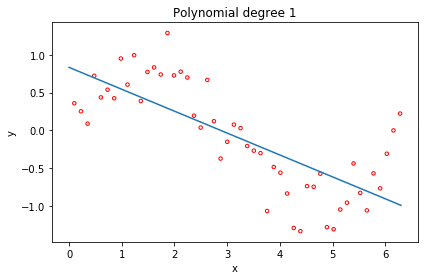

In [86]:
polynomial_regression(x, y, 1)

degree=3, rmse=0.2586


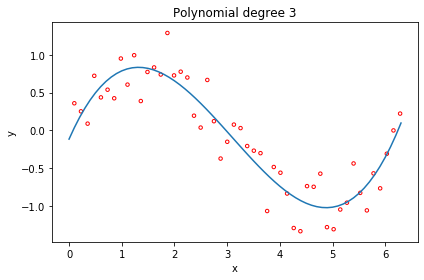

In [87]:
polynomial_regression(x, y, 3)

degree=7, rmse=0.2497


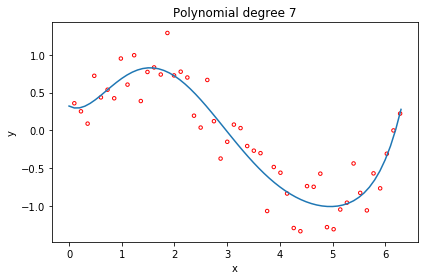

In [88]:
polynomial_regression(x, y, 7)

degree=12, rmse=0.2433


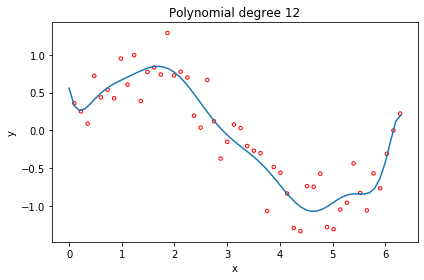

In [89]:
polynomial_regression(x, y, 12)

# 2 Ridge Regression

$\hat{w} = argmin_{w}\{\frac{1}{n}||Xw-y||^2+\alpha||w||_1^2\}$  
  
$\Rightarrow X^TXw-X^Ty+\alpha|w|=0$  
  
$\Rightarrow X^Ty = w(X^TX + \alpha I)$

In [95]:
# Generate weights for the regression
def ridge_regression_w(y, x_mat, alpha):
    a = x_mat.T.dot(x_mat) + alpha * np.identity(x_mat.T.dot(x_mat).shape[0])
    b = x_mat.T.dot(y)
    return np.linalg.solve(a,b)

In [96]:
def split_data(x, y, ratio, seed=576):
    np.random.seed(seed)
    n = len(y)
    indices = np.random.permutation(n)
    split = int(np.floor(ratio * n))
    train = indices[:split]
    test = indices[split:]
    x_train = x[train]
    x_test = x[test]
    y_train = y[train]
    y_test = y[test]
    return x_train, x_test, y_train, y_test

In [97]:
def plot_train_test(train_err, test_err, lambdas, degree):
    fig, ax = plt.subplots(1,1)
    ax.semilogx(lambdas, train_err, color='b', marker='*', label='Train Error') #Make a plot with log scaling on the x axis.
    ax.semilogx(lambdas, test_err, color='r', marker='*', label='Test Error')
    ax.set_xlabel('lambda')
    ax.set_ylabel('RMSE')
    ax.set_title('Ridge Regression for Polynomial Degree' + str(degree))
    legend = ax.legend(loc=0, shadow=True)
    legend.draw_frame(False)

In [98]:
def ridge_regression(x, y, degree, ratio, seed=576):    
    lambdas = np.logspace(-3, 0, 15)
    
    x_train, x_test, y_train, y_test = split_data(x, y, ratio, seed=seed)
    x_mat_train = build_poly(x_train, degree)
    x_mat_test = build_poly(x_test, degree)
    
    rmse_train = []
    rmse_test = []
    for ind, lambda_ in enumerate(lambdas):
        w = ridge_regression_w(y_train, x_mat_train, lambda_)
        rmse_train.append(np.sqrt(2 * mse(y_train, x_mat_train, w)))
        rmse_test.append(np.sqrt(2 * mse(y_test, x_mat_test, w)))
        
        print("proportion={p}, degree={d}, alpha={l:.3f}, Training RMSE={tr:.5f}, Testing RMSE={te:.5f}".format(
               p=ratio, d=degree, l=lambda_, tr=rmse_train[ind], te=rmse_test[ind]))
    plot_train_test(rmse_train, rmse_test, lambdas, degree)

proportion=0.8, degree=7, alpha=0.001, Training RMSE=0.25135, Testing RMSE=0.25062
proportion=0.8, degree=7, alpha=0.002, Training RMSE=0.25139, Testing RMSE=0.25061
proportion=0.8, degree=7, alpha=0.003, Training RMSE=0.25144, Testing RMSE=0.25061
proportion=0.8, degree=7, alpha=0.004, Training RMSE=0.25151, Testing RMSE=0.25060
proportion=0.8, degree=7, alpha=0.007, Training RMSE=0.25158, Testing RMSE=0.25058
proportion=0.8, degree=7, alpha=0.012, Training RMSE=0.25165, Testing RMSE=0.25053
proportion=0.8, degree=7, alpha=0.019, Training RMSE=0.25170, Testing RMSE=0.25046
proportion=0.8, degree=7, alpha=0.032, Training RMSE=0.25174, Testing RMSE=0.25034
proportion=0.8, degree=7, alpha=0.052, Training RMSE=0.25179, Testing RMSE=0.25019
proportion=0.8, degree=7, alpha=0.085, Training RMSE=0.25184, Testing RMSE=0.25002
proportion=0.8, degree=7, alpha=0.139, Training RMSE=0.25190, Testing RMSE=0.24989
proportion=0.8, degree=7, alpha=0.228, Training RMSE=0.25199, Testing RMSE=0.24984
prop

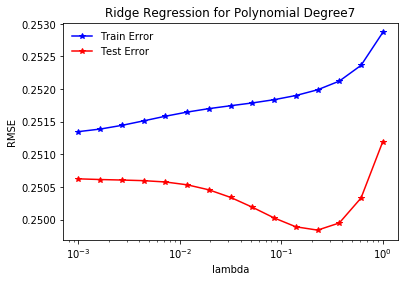

In [99]:
ridge_regression(x, y, 7, 0.8, seed=576)

# 3 LASSO(Least Absolute Shrinkage and Selection Operator)

https://kknews.cc/zh-tw/code/8x9bgjl.html

https://medium.com/%E6%95%B8%E5%AD%B8-%E4%BA%BA%E5%B7%A5%E6%99%BA%E6%85%A7%E8%88%87%E8%9F%92%E8%9B%87/%E6%8A%95%E5%BD%B1%E6%A2%AF%E5%BA%A6%E4%B8%8B%E9%99%8D%E6%B3%95%E8%A7%A3%E6%AD%A3%E5%89%87%E5%8C%96%E5%95%8F%E9%A1%8C-%E4%BB%A5lasso%E5%9B%9E%E6%AD%B8%E7%82%BA%E4%BE%8B-6fc70e4efe65

In [119]:
def lasso(y, x_mat, lambda_):
    n = len(y)
    w_hat = x_mat.T.dot(y) / n
    w = []
    for i in range(len(w_hat)):
        if w_hat[i] > 0:
            sign = 1
        elif w_hat[i] < 0:
            sign = -1
        else:
            sign = 0
        a = np.abs(w_hat[i]) - (lambda_/2)
        if a <= 0:
            b = 0
        else:
            b = a
        w.append(sign * b)
    return w

In [102]:
x_mat = build_poly(x, 13)

In [121]:
lasso(y, x_mat, 0.5)

[0,
 -0.9997012083913612,
 -6.904409512951146,
 -36.89629866573394,
 -189.62751707851902,
 -974.2222589583407,
 -5047.219560321394,
 -26409.82250168081,
 -139513.380223925,
 -743322.9274672393,
 -3990010.8093645843,
 -21554723.507448763,
 -117071934.78596315,
 -638721614.3025118]